In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
tf.enable_v2_behavior()

print(tf.__version__)

2.3.0


In [2]:
mnist_shape = (28, 28, 1)

# Классификатор

## Получение датасета MNIST и создание тренировочных и тестовых выборок

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

### Нормализация изображения ({0, ..., 255} -> [0;1])

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.0, label

### Тренировочный набор

In [5]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Тестовый набор

In [6]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Модель

In [7]:
def define_classifier(shape_input):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer

    # 1 блок слоёв.
    next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 4, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Activation(tf.keras.activations.tanh)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.2)(next_layer)
    #next_layer = tf.keras.layers.SpatialDropout2D(0.1)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(next_layer)

    output_layer_1 = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(next_layer)

    # 2 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Activation(tf.keras.activations.tanh)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    #next_layer = tf.keras.layers.SpatialDropout2D(0.05)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    output_layer_2 = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(next_layer)

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Activation(tf.keras.activations.tanh)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.2)(next_layer)
    #next_layer = tf.keras.layers.SpatialDropout2D(0.2)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    output_layer_3 = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(next_layer)

    # Вывод.
    next_layer = tf.keras.layers.Flatten()(next_layer)
    next_layer = tf.keras.layers.Dense(10)(next_layer)
    output_layer = tf.keras.layers.Activation('softmax')(next_layer)

    # Модель.
    model = tf.keras.models.Model(input_layer, output_layer)
    debug_model = tf.keras.models.Model([input_layer], [output_layer_1, output_layer_2, output_layer_3])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, loss_weights = [1.0], metrics=['accuracy'])
    return model, debug_model

In [8]:
classifier, debug_classifier = define_classifier(mnist_shape)
# Сводка по модели.
classifier.summary()
# Отрисовка модели.
#tf.keras.utils.plot_model(classifier, show_shapes = True, show_layer_names = True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 4)         16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)        

In [9]:
classifier.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 9s 18ms/step - loss: 0.3914 - accuracy: 0.8845 - val_loss: 0.8778 - val_accuracy: 0.7447
Epoch 2/6
469/469 [==============================] - 8s 18ms/step - loss: 0.1251 - accuracy: 0.9620 - val_loss: 0.1026 - val_accuracy: 0.9692
Epoch 3/6
469/469 [==============================] - 8s 17ms/step - loss: 0.0970 - accuracy: 0.9694 - val_loss: 0.0605 - val_accuracy: 0.9820
Epoch 4/6
469/469 [==============================] - 8s 17ms/step - loss: 0.0862 - accuracy: 0.9728 - val_loss: 0.0693 - val_accuracy: 0.9785
Epoch 5/6
469/469 [==============================] - 8s 17ms/step - loss: 0.0800 - accuracy: 0.9751 - val_loss: 0.0554 - val_accuracy: 0.9832
Epoch 6/6
469/469 [==============================] - 8s 18ms/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.0485 - val_accuracy: 0.9863


In [10]:
classifier.save('classifier.h5')
debug_classifier.save('debug_classifier.h5')

### Визуальная проверка

In [11]:
def imshow_array(array):
    plt.axis('off')
    plt.imshow((255.0 * array).astype(np.uint8), cmap=plt.get_cmap("gray"), vmin=0, vmax=255)

In [12]:
(ds_full, _) = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

In [13]:
ds_full = ds_full.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_full = ds_full.batch(1)
#ds_full = ds_full.cache()
#ds_full = ds_full.prefetch(tf.data.experimental.AUTOTUNE)

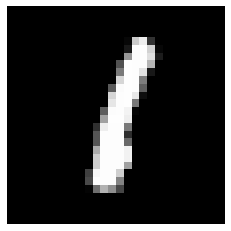

Label: 1
[1.1360934e-03 9.7245640e-01 6.1955344e-04 6.6093387e-05 8.3257249e-03
 6.0626877e-05 1.3324983e-02 4.3590258e-05 3.9095567e-03 5.7416026e-05]


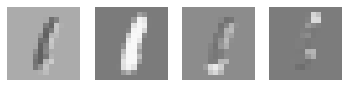

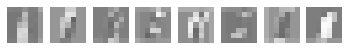

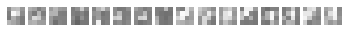

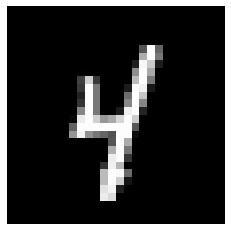

Label: 4
[1.0870459e-05 2.9857210e-03 2.1052829e-05 2.8176025e-06 9.9563110e-01
 6.2220411e-06 1.2502821e-06 5.0404947e-04 1.8206477e-04 6.5475225e-04]


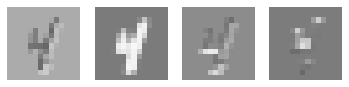

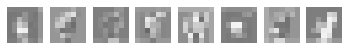

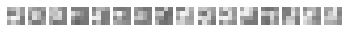

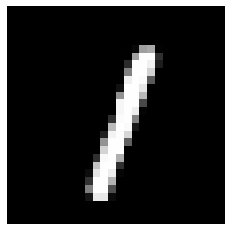

Label: 1
[1.2296689e-04 9.9639004e-01 5.1476458e-05 8.5012493e-07 2.6440397e-03
 1.7143100e-06 1.8709958e-05 7.2558905e-04 1.0962186e-05 3.3685857e-05]


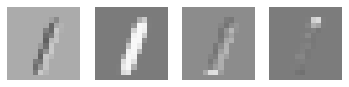

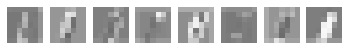

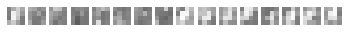

In [14]:
import matplotlib.pyplot as plt
import numpy as np

mnist_example = ds_full.take(3)
for sample in mnist_example:
    image, label = sample[0].numpy(), sample[1].numpy()
    imshow_array(image[:, :, 0])
    plt.show()
    print("Label: %d" % label)

    # Предсказание.
    print(classifier.predict(np.array([image]))[0])

    # Отрисовка слоёв.
    debug = debug_classifier.predict(np.array([image]))
    for output in debug:
        for element in output:
            element = np.swapaxes(element, 0, 2)
            element = np.swapaxes(element, 1, 2)

            i = 0
            n = len(element)
            for filter in element:
                plt.subplot(1, n, 1 + i)
                imshow_array(filter)
                i += 1

            plt.show()

# Kernel density

#### Полный датасет без разбиения по комплектам

In [15]:
def normalize_crop(x):
    return min(1.0, max(0.0, x))

In [16]:
samples = list(ds_full.take(-1))
images = [sample[0].numpy().reshape(28,28) for sample in samples]
labels = [sample[1].numpy() for sample in samples]

images_vectors = [image.reshape(28*28) for image in images]

#### PCA-преобразование

In [17]:
from sklearn.decomposition import PCA

pca_images = PCA(n_components=10, whiten=False)
images_vectors_pca = pca_images.fit_transform(images_vectors)

#### Визуальная проверка PCA-преобразования

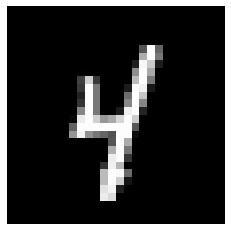

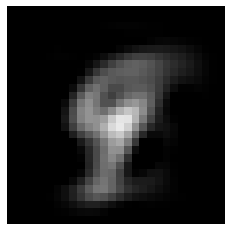

In [18]:
test = pca_images.inverse_transform(images_vectors_pca[0])
test = test.reshape(28,28)
test = np.vectorize(normalize_crop)(test)

imshow_array(images[0])
plt.show()
imshow_array(test)
plt.show()

### Инициализация и обучение модели KDE

#### Оптимизация ширины

In [19]:
from sklearn.neighbors import KernelDensity
#from sklearn.model_selection import GridSearchCV

#params = {'bandwidth': np.logspace(-1, 0, 20)}
#grid = GridSearchCV(KernelDensity(), params)
#grid.fit(lowdim_vectors)

In [20]:
kde_images = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_images.fit(images_vectors_pca)
#kde_images = grid.best_estimator_
print(kde_images.get_params())

{'algorithm': 'auto', 'atol': 0, 'bandwidth': 0.25, 'breadth_first': True, 'kernel': 'gaussian', 'leaf_size': 40, 'metric': 'euclidean', 'metric_params': None, 'rtol': 0}


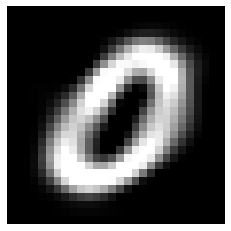

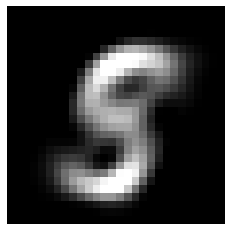

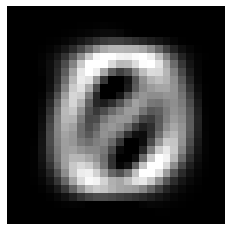

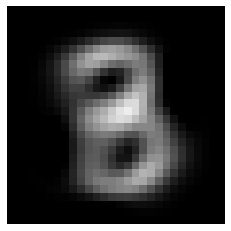

In [21]:
for i in range(4):
    test = kde_images.sample()#(random_state=i)
    test = pca_images.inverse_transform(test)
    test = test.reshape(28,28)
    test = np.vectorize(normalize_crop)(test)

    imshow_array(test)
    plt.show()

# Автоэнкодер

In [46]:
ds_train_images, ds_test_images = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True
)

In [47]:
def relabel_to_image(image, label):
    return image, image

In [48]:
ds_train_images = ds_train_images.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_images = ds_train_images.map(
    relabel_to_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_images = ds_train_images.cache()
ds_train_images = ds_train_images.shuffle(ds_info.splits['train'].num_examples)
ds_train_images = ds_train_images.batch(128)
ds_train_images = ds_train_images.prefetch(tf.data.experimental.AUTOTUNE)

In [49]:
ds_test_images = ds_test_images.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images = ds_test_images.map(
    relabel_to_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images = ds_test_images.batch(128)
ds_test_images = ds_test_images.cache()
ds_test_images = ds_test_images.prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
def similarity_loss(y_true, y_pred):
    delta = tf.keras.backend.abs(y_true - y_pred)
    squared = tf.keras.backend.square(y_true - y_pred)
    return tf.keras.backend.mean(delta - 0.5 * squared, axis=-1)

In [42]:
def define_autoencoder(shape_input, dimension):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer

    # 1 блок слоёв.
    next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.2)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # 2 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.2)(next_layer)
    next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(next_layer)

    # Бутылочное горлышко.
    next_layer = tf.keras.layers.Flatten()(next_layer)
    next_layer = tf.keras.layers.Dense(dimension)(next_layer)
    bottleneck = tf.keras.layers.Activation('sigmoid')(next_layer)

    # Модель кодировщика.
    encoder = tf.keras.Model(input_layer, bottleneck)

    # Начало модели декодировщика.
    input_code_layer = tf.keras.layers.Input((dimension))
    next_layer = input_code_layer

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.Dense(4*4*32)(next_layer)
    next_layer = tf.keras.layers.Reshape((4, 4, 32))(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.2)(next_layer)

    # 2 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.Cropping2D(cropping=((0, 1), (0, 1)))(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    # 1 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    # 0 блок слоёв.
    #next_layer = tf.keras.layers.GaussianNoise(0.1)(input_layer)
    next_layer = tf.keras.layers.UpSampling2D(size=(2, 2))(next_layer)
    next_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.BatchNormalization()(next_layer)
    next_layer = tf.keras.layers.Activation('sigmoid')(next_layer)
    #next_layer = tf.keras.layers.Dropout(0.1)(next_layer)

    output_layer = next_layer

    # Модель.
    decoder = tf.keras.models.Model(input_code_layer, output_layer) # Декодировщик.
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(lr = 0.001)
    autoencoder.compile(loss = similarity_loss, optimizer = opt, loss_weights = [1.0])
    return encoder, decoder, autoencoder

In [43]:
codes_dim = 16
encoder, decoder, autoencoder = define_autoencoder(mnist_shape, codes_dim)

In [44]:
# Сводка по модели.
encoder.summary()
# Отрисовка модели.
#tf.keras.utils.plot_model(encoder, show_shapes = True, show_layer_names = True)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 16)      

In [45]:
# Сводка по модели.
decoder.summary()
# Отрисовка модели.
#tf.keras.utils.plot_model(decoder, show_shapes = True, show_layer_names = True)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               8704      
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 4, 4, 32)          128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 32)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 32)        

In [50]:
#encoder = tf.eras.models.load_model('path/to/location')

autoencoder.fit(
    ds_train_images,
    epochs=16,
    validation_data=ds_test_images,
)

Epoch 1/16
469/469 [==============================] - 29s 62ms/step - loss: 0.2537 - val_loss: 0.2066
Epoch 2/16
469/469 [==============================] - 29s 62ms/step - loss: 0.1792 - val_loss: 0.1418
Epoch 3/16
469/469 [==============================] - 28s 59ms/step - loss: 0.1298 - val_loss: 0.1039
Epoch 4/16
469/469 [==============================] - 28s 59ms/step - loss: 0.0990 - val_loss: 0.0856
Epoch 5/16
469/469 [==============================] - 28s 60ms/step - loss: 0.0796 - val_loss: 0.0682
Epoch 6/16
469/469 [==============================] - 28s 60ms/step - loss: 0.0668 - val_loss: 0.0575
Epoch 7/16
469/469 [==============================] - 28s 60ms/step - loss: 0.0580 - val_loss: 0.0499
Epoch 8/16
469/469 [==============================] - 28s 60ms/step - loss: 0.0518 - val_loss: 0.0426
Epoch 9/16
469/469 [==============================] - 28s 60ms/step - loss: 0.0473 - val_loss: 0.0371
Epoch 10/16
469/469 [==============================] - 28s 60ms/step - loss: 0.043

In [51]:
autoencoder.save('autoencoder.h5')
encoder.save('encoder.h5')
decoder.save('decoder.h5')

### Визуальная проверка

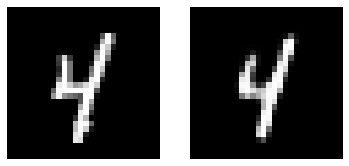

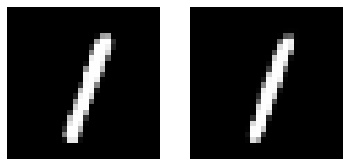

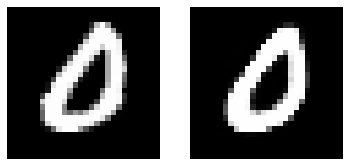

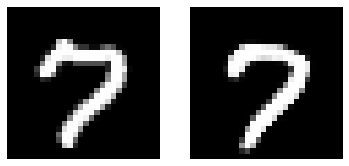

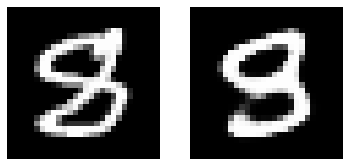

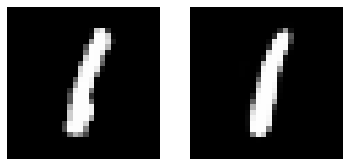

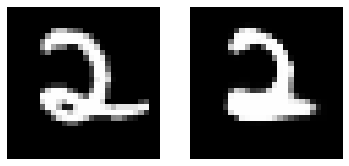

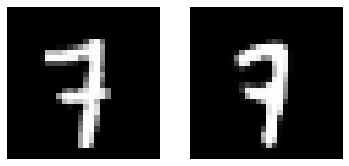

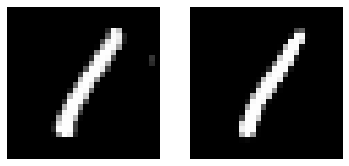

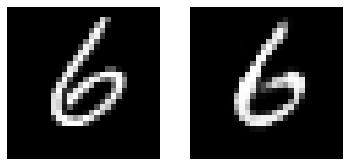

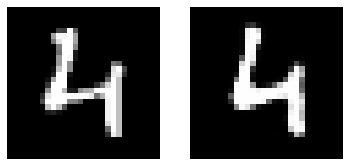

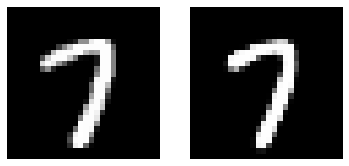

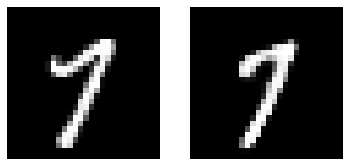

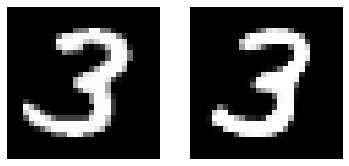

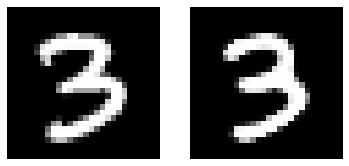

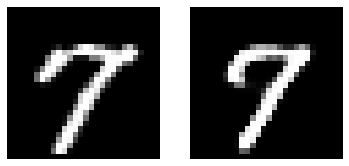

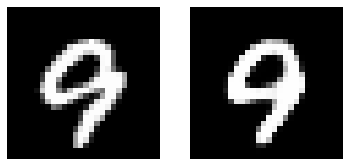

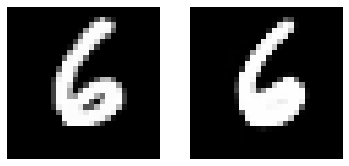

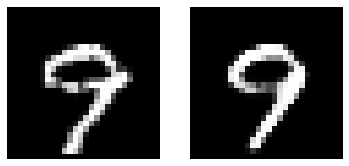

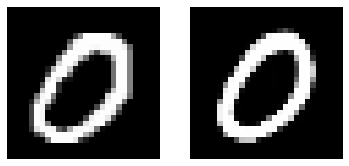

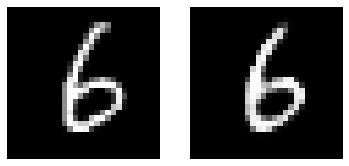

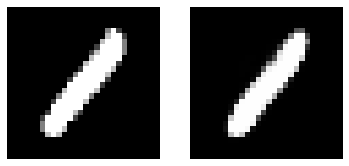

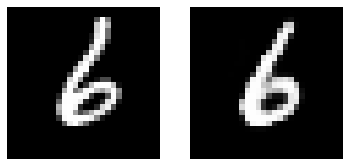

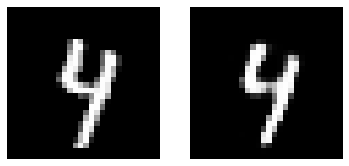

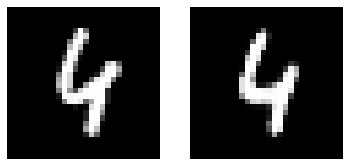

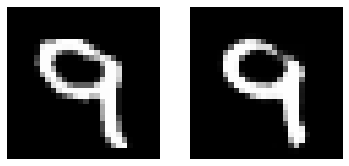

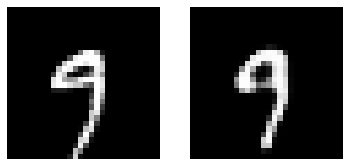

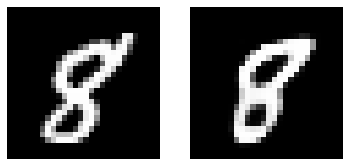

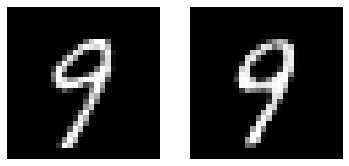

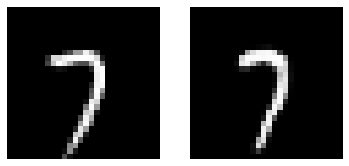

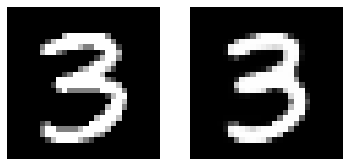

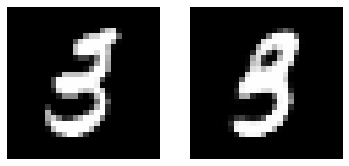

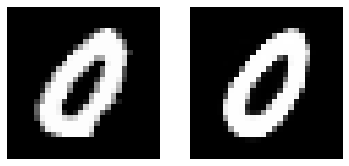

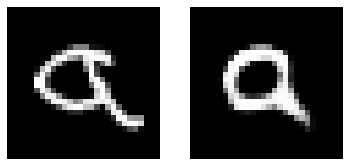

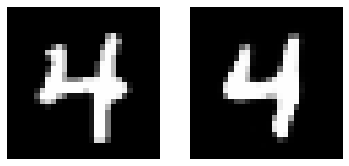

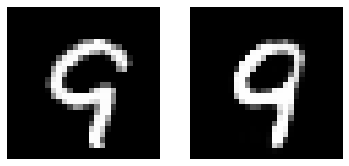

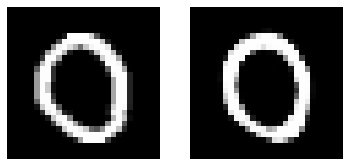

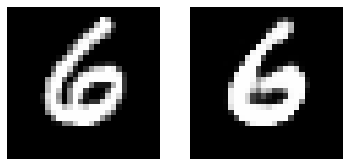

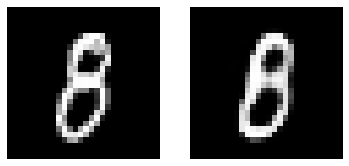

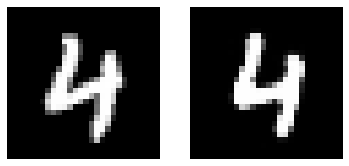

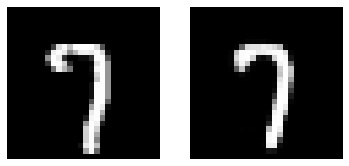

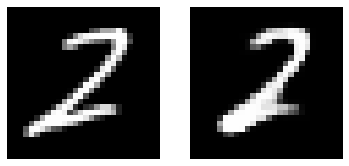

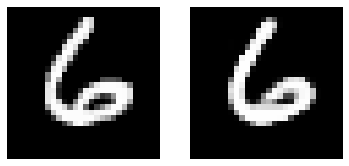

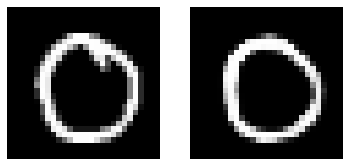

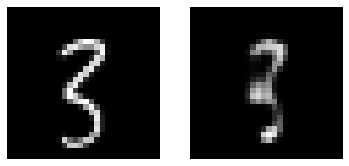

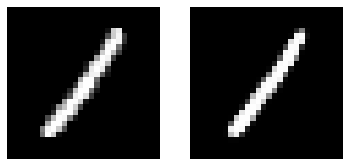

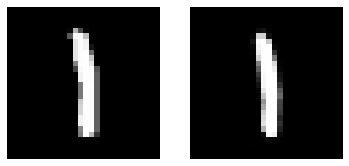

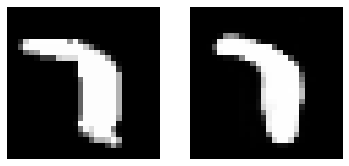

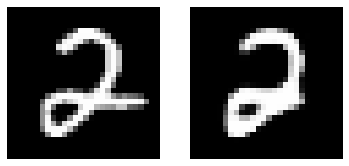

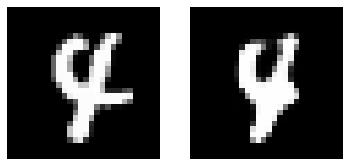

In [52]:
mnist_example = ds_full.take(50)
for sample in mnist_example:
    image, label = sample[0].numpy(), sample[1].numpy()

    plt.subplot(1, 2, 1)
    imshow_array(image[:, :, 0])
    #plt.show()

    # Предсказание.
    plt.subplot(1, 2, 2)
    imshow_array(autoencoder.predict(np.array([image]))[0][:, :, 0])
    plt.show()

### Получение кодов всех изображений датасета

In [107]:
samples = list(ds_full.take(-1))
images = np.array([sample[0].numpy().reshape(28,28,1) for sample in samples])
codes = encoder.predict(images)

In [108]:
from sklearn.decomposition import PCA

pca_codes_dim = 16
pca_codes = PCA(n_components=pca_codes_dim, whiten=False)
codes_pca = pca_codes.fit_transform(codes)

In [83]:
def _interact_pca(code_pca):
    print(code_pca)
    imshow_array(decoder.predict(np.array([pca_codes.inverse_transform(code_pca)]))[0][:, :, 0])
    plt.show()

In [84]:
"""def _interact_pca_first16(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16):
    code_pca = np.zeros(pca_codes_dim)
    code_pca[0] = x1
    code_pca[1] = x2
    code_pca[2] = x3
    code_pca[3] = x4
    code_pca[4] = x5
    code_pca[5] = x6
    code_pca[6] = x7
    code_pca[7] = x8
    code_pca[8] = x9
    code_pca[9] = x10
    code_pca[10] = x11
    code_pca[11] = x12
    code_pca[12] = x13
    code_pca[13] = x14
    code_pca[14] = x15
    code_pca[15] = x16
    
    imshow_array(decoder.predict(np.array([pca_codes.inverse_transform(code_pca)]))[0][:, :, 0])
    plt.show()"""

'def _interact_pca_first16(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16):\n    code_pca = np.zeros(pca_codes_dim)\n    code_pca[0] = x1\n    code_pca[1] = x2\n    code_pca[2] = x3\n    code_pca[3] = x4\n    code_pca[4] = x5\n    code_pca[5] = x6\n    code_pca[6] = x7\n    code_pca[7] = x8\n    code_pca[8] = x9\n    code_pca[9] = x10\n    code_pca[10] = x11\n    code_pca[11] = x12\n    code_pca[12] = x13\n    code_pca[13] = x14\n    code_pca[14] = x15\n    code_pca[15] = x16\n    \n    imshow_array(decoder.predict(np.array([pca_codes.inverse_transform(code_pca)]))[0][:, :, 0])\n    plt.show()'

In [85]:
"""import ipywidgets as ipw

_min = -1.0
_max = 1.0
_step = 0.01
ipw.interact(_interact_pca_first16,
             x1=(_min, _max, _step),
             x2=(_min, _max, _step),
             x3=(_min, _max, _step),
             x4=(_min, _max, _step),
             x5=(_min, _max, _step),
             x6=(_min, _max, _step),
             x7=(_min, _max, _step),
             x8=(_min, _max, _step),
             x9=(_min, _max, _step),
             x10=(_min, _max, _step),
             x11=(_min, _max, _step),
             x12=(_min, _max, _step),
             x13=(_min, _max, _step),
             x14=(_min, _max, _step),
             x15=(_min, _max, _step),
             x16=(_min, _max, _step))"""

'import ipywidgets as ipw\n\n_min = -1.0\n_max = 1.0\n_step = 0.01\nipw.interact(_interact_pca_first16,\n             x1=(_min, _max, _step),\n             x2=(_min, _max, _step),\n             x3=(_min, _max, _step),\n             x4=(_min, _max, _step),\n             x5=(_min, _max, _step),\n             x6=(_min, _max, _step),\n             x7=(_min, _max, _step),\n             x8=(_min, _max, _step),\n             x9=(_min, _max, _step),\n             x10=(_min, _max, _step),\n             x11=(_min, _max, _step),\n             x12=(_min, _max, _step),\n             x13=(_min, _max, _step),\n             x14=(_min, _max, _step),\n             x15=(_min, _max, _step),\n             x16=(_min, _max, _step))'

In [86]:
#class WidgetsArray:
#    def __init__(self, array):
#        self.array = array
#        self.value = [widget.value for widget in self.array]
#        
#    def observe(self, a, b):
#        for widget in self.array:
#            widget.observe(a, b)
#            
#        self.value = [widget.value for widget in self.array]

In [87]:
#import ipywidgets as ipw

#sliders_array = [ipw.widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1) for i in range(pca_codes_dim)]
#sliders = WidgetsArray(sliders_array)
#ui = ipw.widgets.VBox(sliders_array)
#out = ipw.widgets.interactive_output(_interact_pca, {'code_pca': sliders})

#display(ui, out)

### KDE для кодов

In [127]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.linspace(0.02, 0.08, 8), 'rtol': [0.001]}
grid = GridSearchCV(KernelDensity(), params, n_jobs=16)
grid.fit(codes_pca)

GridSearchCV(cv=None, error_score=nan,
             estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0,
                                     breadth_first=True, kernel='gaussian',
                                     leaf_size=40, metric='euclidean',
                                     metric_params=None, rtol=0),
             iid='deprecated', n_jobs=16,
             param_grid={'bandwidth': array([0.02      , 0.02857143, 0.03714286, 0.04571429, 0.05428571,
       0.06285714, 0.07142857, 0.08      ]),
                         'rtol': [0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [170]:
kde_codes = KernelDensity(bandwidth=0.054285714285714284, kernel='gaussian')
kde_codes.fit(codes_pca)
#kde_codes = grid.best_estimator_
print(kde_codes.get_params())

{'algorithm': 'auto', 'atol': 0, 'bandwidth': 0.054285714285714284, 'breadth_first': True, 'kernel': 'gaussian', 'leaf_size': 40, 'metric': 'euclidean', 'metric_params': None, 'rtol': 0}


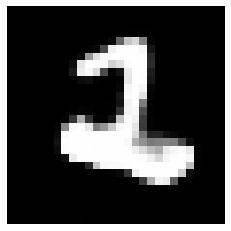

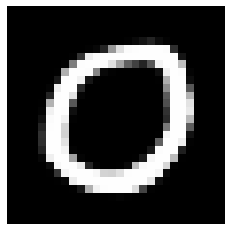

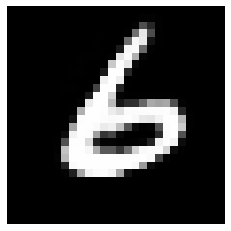

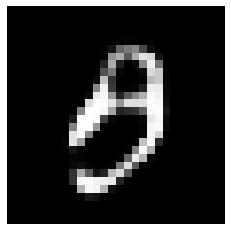

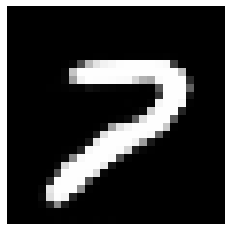

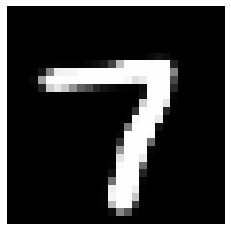

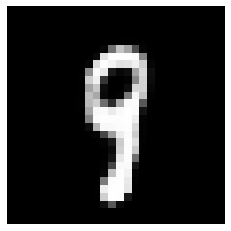

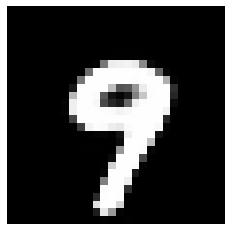

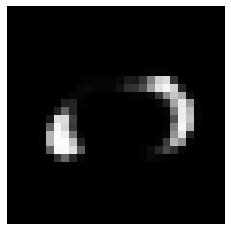

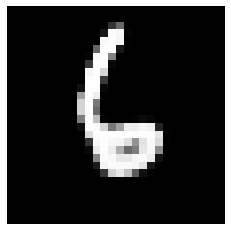

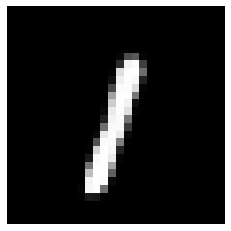

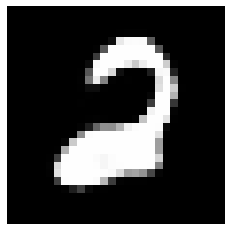

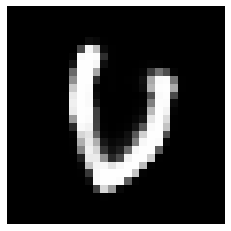

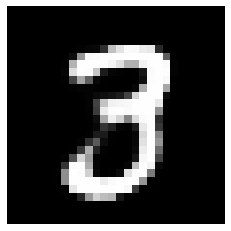

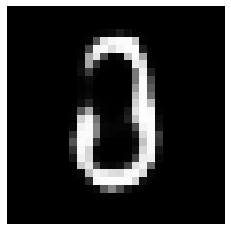

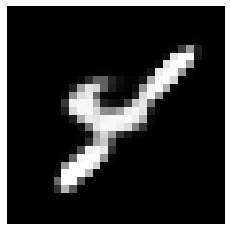

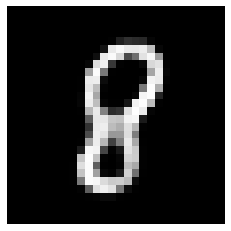

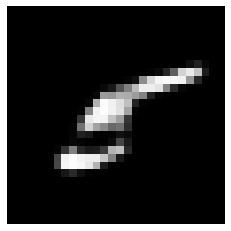

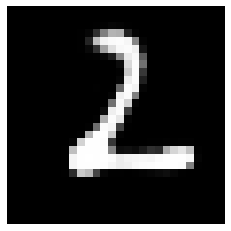

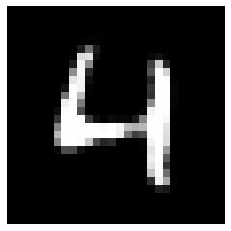

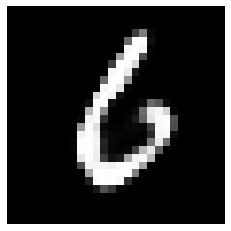

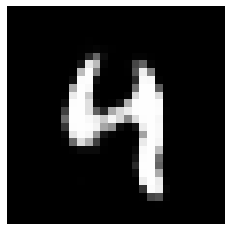

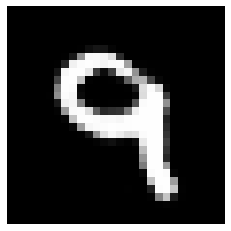

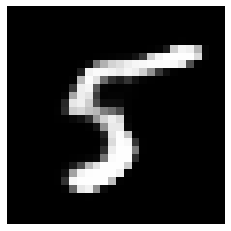

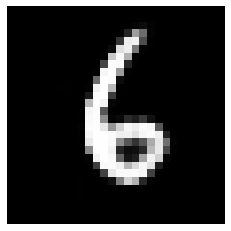

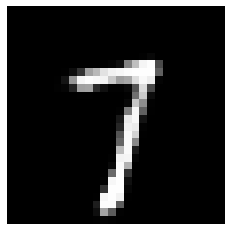

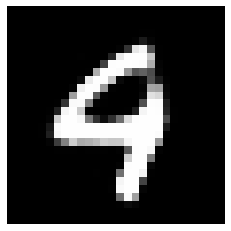

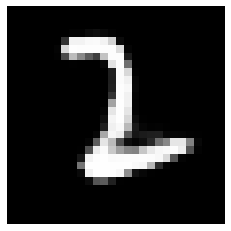

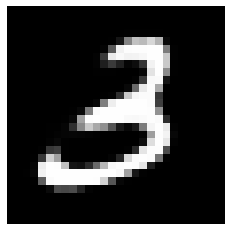

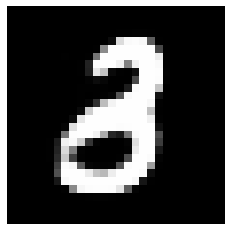

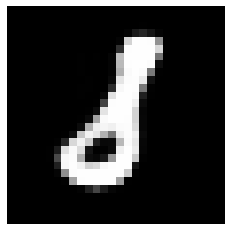

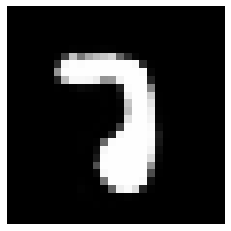

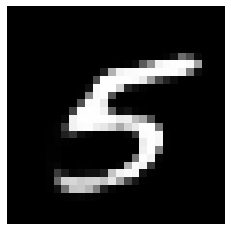

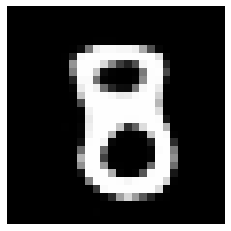

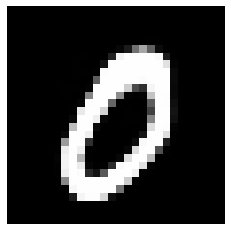

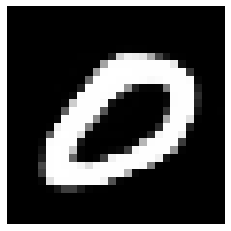

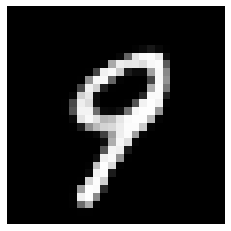

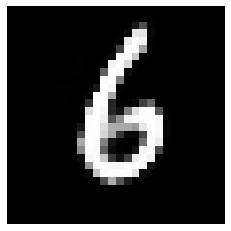

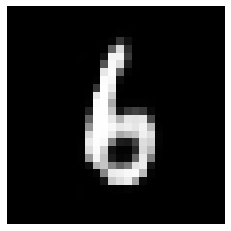

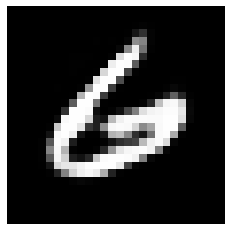

In [171]:
for i in range(40):
    test = kde_codes.sample()#(random_state=i)
    test = pca_codes.inverse_transform(test)
    
    
    imshow_array(decoder.predict(test)[0][:, :, 0])
    plt.show()

## Подсчёт энтропии

In [176]:
def entropy_monte_carlo(kde, N):
    sum = 0.0
    for i in range(1, N + 1):
        sum += kde.score_samples(kde.sample())[0]
        print("H: %f" % (sum / i), end="\r")
        
    return sum / N

In [177]:
entropy_monte_carlo(kde_codes, 10000)

13.858675863794385

In [166]:
def entropy_multivariate_normal(dimension, dispersion):
    return 0.5 * dimension * (1 + np.log(2 * np.pi) + 0.5 * np.log(dispersion))

In [167]:
entropy_multivariate_normal(pca_codes_dim, kde_codes.get_params()['bandwidth'])

11.049039830006688